In [177]:
import nltk
import string
import torch
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math

from sentence_transformers import SentenceTransformer, util
# Load the Sentence Transformer model 
model = SentenceTransformer('all-mpnet-base-v2')  

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)


In [193]:
# funzione che rimuove le stopwords, segni di punteggiatura e numeri
def clean_phrase(phrase):
    words = word_tokenize(phrase.lower())
    cleaned_words = [word for word in words if word.lower() not in stop_words and word not in punctuation and not word.isdigit() and word !="''"]
    return cleaned_words

#restituisce il calcolo della cosine similarity tra due blocchi
def cosine_similarity(block1,block2):
    block1 = [clean_phrase(phrase) for phrase in block1]
    block2 = [clean_phrase(phrase) for phrase in block2]
    block1_merged= [word for sublist in block1 for word in sublist]
    block2_merged= [word for sublist in block2 for word in sublist]
    block1_dict = Counter(block1_merged)
    block2_dict = Counter(block2_merged)
    words = list(block1_dict.keys() | block2_dict.keys())
    numerator=0
    denominator_1=0
    denominator_2=0
    for word in words:
        numerator+=block1_dict[word]*block2_dict[word]
        denominator_1 += block1_dict[word]**2  
        denominator_2 += block2_dict[word]**2
    cos_sim=numerator / math.sqrt(denominator_1 * denominator_2)
    return cos_sim

#Calcola la somiglianza tra due liste di stringhe della stessa dimensione usando i Transformers
def sentence_transformer_similarity(block1, block2):
  AGGREGATION="average"
  # Get sentence embeddings
  embeddings1 = model.encode(block1)
  embeddings2 = model.encode(block2)

  # Calculate pairwise cosine similarities
  similarities = util.pytorch_cos_sim(embeddings1, embeddings2)

  # Handle potential empty similarity matrix (all sentences might be identical)
  if similarities.shape[0] == 1 and similarities.shape[1] == 1:
    return similarities.item()

  # Aggregate pairwise similarities
  if AGGREGATION == "average":
    similarity = torch.mean(similarities).item()
  elif AGGREGATION == "max":
    similarity = torch.max(similarities).item()
  else:
    raise ValueError(f"Invalid aggregation method: {AGGREGATION}")

  similarities = np.dot(embeddings1, np.transpose(embeddings2))
  similarity = np.mean(similarities)
  
  return similarity   



# trova tutte le occorrenze di '<SECTION_SEP>' in un documento
def find_section_start_indices(text):  
    sections=text.split('<SECTION_SEP>')
    boundaries=[]
    count=1
    for sec in sections[:-1]:
        sentences=sec.split('<SENTENCE_SEP>')[:-1]
        count+=len(sentences)
        boundaries.append(count)
    return boundaries


def plot_similiraty(graph,similarity,smoothed_similarities,actual_boundaries,predicted_boundaries,block_len,name):
    
    xpoints = np.arange(1,(len(smoothed_similarities)*block_len)+1,block_len)
    ypoints = similarity
    xpoints_smooth = np.arange(1,(len(smoothed_similarities)*block_len)+1,block_len)
    ypoints_smooth = smoothed_similarities
    graph.plot(xpoints, ypoints, '-o', color='red', label='Similarities')
    graph.plot(xpoints_smooth, ypoints_smooth, '-o', color='blue', label='Smoothed similarities')
    graph.set_title(name) 


    
    for p_d in predicted_boundaries:
        if p_d not in actual_boundaries:
            graph.axvline(x=(p_d-1), color='black', label='Matched boundaries')
        else:
            graph.axvline(x=(p_d-1), color='magenta', label='Predicted boundaries')
            
    for a_b in actual_boundaries:
        if a_b not in predicted_boundaries:
          graph.axvline(x=(a_b-1), color='green', label='Actual boundaries')


      



def get_boundaries(similarities,block_len,SECTION_SENS):
    
    depth_score_sim=[]
    for i in range(1,len(similarities)-1):
        score=(similarities[i-1]-similarities[i])+(similarities[i+1]-similarities[i])
        depth_score_sim.append(score)
    depth_score_sim.insert(0,similarities[1]-similarities[0])
    depth_score_sim.append(similarities[-2]-similarities[-1])

    filtered=list(filter(lambda x: x > 0, depth_score_sim))
    std=np.std(filtered)
    mean=np.mean(filtered)
    threshold=(mean-(std/SECTION_SENS))

    boundaries= [i for i, v in enumerate(depth_score_sim) if v > threshold]
    boundaries = [(x*block_len)+2 for x in boundaries]
    return boundaries

def boundaries_error(actual,predicted):
  errors=[]
  for boundary in actual:
    min_edit_distance=6000
    for pr in predicted:
      edit_distance=abs(boundary-pr)
      if(edit_distance<min_edit_distance):
        min_edit_distance=edit_distance
    errors.append(min_edit_distance)
  return sum(errors)

def extrack_blocks(N_BLOCK, doc):
    blocks = []
    for i in range(0, len(doc), N_BLOCK):
        if i + (N_BLOCK-1) < len(doc):
            blocks.append(doc[i:i + N_BLOCK])
        else:
            blocks.append(doc[i:])
    return blocks

In [194]:


#contiene i documenti
df = pd.read_csv("data\\wiki_definitions.csv")  
docs=df["definitions"].astype(str).tolist()
doc_names=df["names"].astype(str).tolist()


#contiene, per ogni documento, gli indici dei separatori di paragrafo (in base alla frase)
docs_sections=[]
for doc in docs:
    sections_pos=find_section_start_indices(doc)
    docs_sections.append(sections_pos)


#contiene i documenti, ma separati frase per frase
docs_sent_by_sent=[]
for doc in docs:
    doc_t=doc.replace('<SECTION_SEP>','')
    doc_t=doc_t.replace('\r', '').replace('\n', '')
    doc_splitted=doc_t.split('<SENTENCE_SEP>')
    docs_sent_by_sent.append(doc_splitted)



['The apple is a deciduous tree, generally standing 2 to 4.5 metres (6 to 15 feet) tall in cultivation and up to 9 m (30 ft) in the wild.']
['When cultivated, the size, shape and branch density are determined by rootstock selection and trimming method.']
['When cultivated, the size, shape and branch density are determined by rootstock selection and trimming method.']
['The leaves are alternately arranged dark green-colored simple ovals with serrated margins and slightly downy undersides.']
['The leaves are alternately arranged dark green-colored simple ovals with serrated margins and slightly downy undersides.']
['Blossoms are produced in spring simultaneously with the budding of the leaves and are produced on spurs and some long shoots.']
['Blossoms are produced in spring simultaneously with the budding of the leaves and are produced on spurs and some long shoots.']
['The 3-to-4-centimeter flowers are white with a pink tinge that gradually fades, five petaled, with an inflorescence co

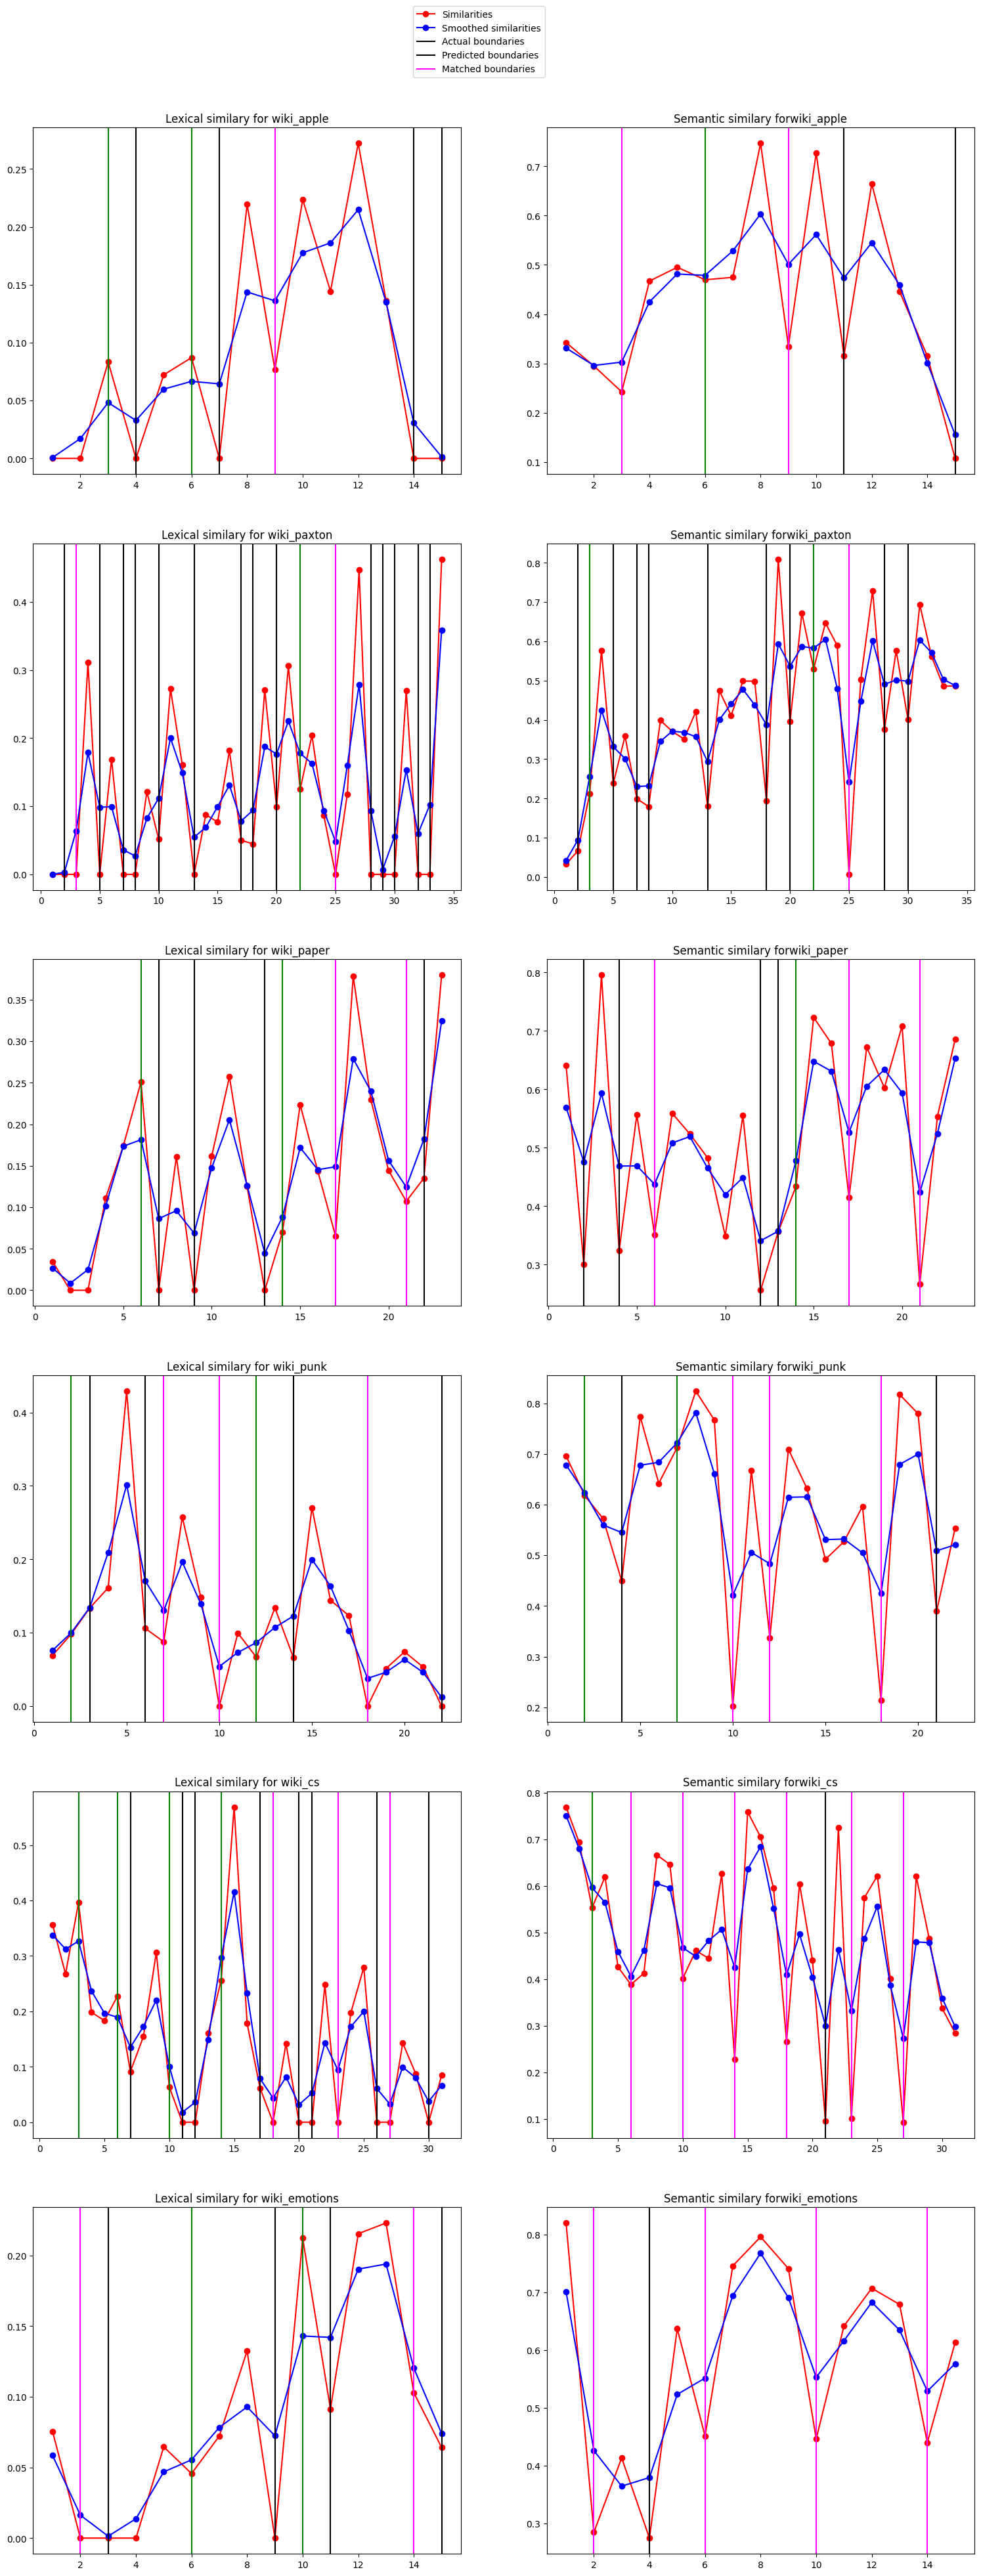

,document,lexical_match_error,semantic_match_error,lexical_number_of_section_error,semantic_number_of_section_error
0,apple,2,3,2,1
1,paxton,2,3,13,7
2,paper,2,1,2,3
3,punk,3,5,2,0
4,computer science,8,3,4,0
5,emotions,4,0,2,1
6,TOTAL,21,15,25,12


Lexical (match+section) error 46
Semantinc (match+section) error 27


,document,lexical_predicted_boundaries,semantic_predicted_boundaries,real_boundaries
0,apple,"[5, 8, 10, 15, 16]","[4, 10, 12, 16]","[4, 7, 10]"
1,paxton,"[3, 4, 6, 8, 9, 11, 14, 18, 19, 21, 26, 29, 30...","[3, 6, 8, 9, 14, 19, 21, 26, 29, 31]","[4, 23, 26]"
2,paper,"[8, 10, 14, 18, 22, 23]","[3, 5, 7, 13, 14, 18, 22]","[7, 15, 18, 22]"
3,punk,"[4, 7, 8, 11, 15, 19, 23]","[5, 11, 13, 19, 22]","[3, 8, 11, 13, 19]"
4,computer science,"[8, 12, 13, 18, 19, 21, 22, 24, 27, 28, 31]","[7, 11, 15, 19, 22, 24, 28]","[4, 7, 11, 15, 19, 24, 28]"
5,emotions,"[3, 4, 10, 12, 15, 16]","[3, 5, 7, 11, 15]","[3, 7, 11, 15]"


In [195]:

#In entrambi impostare N_BLOCK a 3 peggiora le prestazioni
#
#numero di frasi considerate in un blocco 
#1 0.7 2 (47 25) 
#1 0.7 1 (50 30)
#3 0.2 0.5
N_BLOCK=1
SMOOTH=0.7
SECTION_SENS=2


boundaries_list=[]
boundaries_error_list=[]

figure, axis = plt.subplots(len(docs), 2) 
figure.set_size_inches(18.5, 8*(len(docs)))

for DOC_NUM in range(0,len(docs)):

    doc=docs_sent_by_sent[DOC_NUM]
    blocks = extrack_blocks(N_BLOCK, doc)

    lexical_similarities=[]
    transformer_similarities=[]
    for i in range(0,len(blocks)-1):
        print(blocks[i])
        print(blocks[i+1])

        lex_similarity=cosine_similarity(blocks[i],blocks[i+1])
        lexical_similarities.append(lex_similarity)
        bert_similarity=sentence_transformer_similarity(blocks[i],blocks[i+1])
        transformer_similarities.append(bert_similarity)

    smoothed_lexical_similarities=gaussian_filter1d(lexical_similarities, sigma=SMOOTH)
    smoothed_transformer_similarities=gaussian_filter1d(transformer_similarities, sigma=SMOOTH)




    boundaries_lex=get_boundaries(smoothed_lexical_similarities,N_BLOCK,SECTION_SENS)
    boundaries_error_lex=boundaries_error(docs_sections[DOC_NUM],boundaries_lex)

    boundaries_emb=get_boundaries(smoothed_transformer_similarities,N_BLOCK,SECTION_SENS)
    boundaries_error_emb=boundaries_error(docs_sections[DOC_NUM],boundaries_emb)

    boundaries_list.append((boundaries_lex,boundaries_emb))
    boundaries_error_list.append((boundaries_error_lex,boundaries_error_emb))

    
    plot_similiraty(axis[DOC_NUM][0],lexical_similarities,smoothed_lexical_similarities,docs_sections[DOC_NUM],boundaries_lex,N_BLOCK,name="Lexical similary for "+doc_names[DOC_NUM])
    plot_similiraty(axis[DOC_NUM][1],transformer_similarities,smoothed_transformer_similarities,docs_sections[DOC_NUM],boundaries_emb,N_BLOCK,name="Semantic similary for"+doc_names[DOC_NUM])
    


figure.legend(['Similarities','Smoothed similarities','Actual boundaries','Predicted boundaries','Matched boundaries'],bbox_to_anchor=(0.55, 0.92))
plt.show()



errors = {'document': ['apple','paxton', 'paper', 'punk','computer science','emotions'], 
          'lexical_match_error': [i[0] for i in boundaries_error_list],
          'semantic_match_error':  [i[1] for i in boundaries_error_list],
          'lexical_number_of_section_error':  [abs(len(boundaries_list[i][0])-len(docs_sections[i])) for i in range(0,len(docs))] ,
          'semantic_number_of_section_error':  [abs(len(boundaries_list[i][1])-len(docs_sections[i])) for i in range(0,len(docs))] 
          }

pd_errors=pd.DataFrame(errors)
total= pd_errors.sum(numeric_only=True, axis=0)
pd_errors.loc[len(pd_errors.index)] = ['TOTAL', total['lexical_match_error'], total['semantic_match_error'],total['lexical_number_of_section_error'],total['semantic_number_of_section_error']] 

display(pd_errors)

print("Lexical (match+section) error " + str(total['lexical_match_error']+total['lexical_number_of_section_error']))
print("Semantinc (match+section) error " + str(total['semantic_match_error']+total['semantic_number_of_section_error']))


boundaries_to_pd = {'document': ['apple','paxton', 'paper', 'punk','computer science','emotions'], 'lexical_predicted_boundaries': [i[0] for i in boundaries_list],'semantic_predicted_boundaries':  [i[1] for i in boundaries_list],'real_boundaries':  docs_sections}
display(pd.DataFrame(boundaries_to_pd))

